# Web Scraping an E-commerce website with Beautiful Soup

### 

## Step 1: Importing Libraries
First we have to import BeautifulSoup from bs4 as well as the requests library to make an HTTP request using the URL.

We also import some DS libraries to analyze the data later (optional)

In [63]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import seaborn as sns
import matplotlib as plt


### 

## Step 2: Extracting and Parsing the HTML Content
Using the **get** method from the requests library, we obtain the raw html content of the webpage. 

This is a very long string which is quite difficult to work with, so we'll have to parse *(organize)* it.

We use the **html5lib** parser and create a BeautifulSoup object. Now we have a neatly organized html structure.


In [64]:
# In this case, we'll see some headphones (casti = headphones in Romanian)
URL="https://www.emag.ro/search/casti?ref=effective_search"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html5lib')

### 

## Step 3: Navigating in the HTML tree 
Now we'll navigate through the html tree to access the specific data we're looking for.

First we'll scrape the cards of each product using the **findAll** method

After that, we'll iterate through each card to find and store the name, price, num_of_reviews and rating using the **find** method


In [86]:
cards = soup.findAll('div', attrs={"class", "card-item card-standard js-product-data"})

l_names = []
l_ratings = []
l_reviews = []
l_prices = []

for card in cards:
    # Finding the name
    l_names.append(card.find('h2', attrs={'class', 'card-v2-title-wrapper'}).text.strip())
    
    # Finding the rating
    # We get an AttributeError if the product doesn't have a rating, so we fill it with None
    try:
        l_ratings.append(float(card.find('span',attrs={"class", "average-rating semibold"}).text.strip()))
    except AttributeError:
        l_ratings.append(None)
    
    # Finding the number of reviews
    # We get an AttributeError if the product doesn't have any reviews, so we fill it with 0
    try:
        l_reviews.append(int(card.find('span', attrs={'class', 'visible-xs-inline-block'}).text.strip()[1:-1]))
    except AttributeError:
        l_reviews.append("0")
        
    # Finding the price
    # The price is converted from a '###,###.## Lei' String to ''##.##' float
    # First the commas and dots are erased, and the Lei part is erased
    raw_price = card.find('p', attrs={'class', 'product-new-price'}).text.replace(".","").replace(",","").split("Lei")[0].strip()
    # Next, we stick the last 2 digits (bani) and the first digits with a dot in btw (to produce a float later on)
    finalized_price = raw_price[:-2] + "." + raw_price[-2:]
    l_prices.append(float(finalized_price))

### 

## Step 4: Creating a pandas DataFrame and conducting EDA

In [99]:
# Creating a dictionary before creating a dataframe from our cleaned data
dict_data = {
    'name' : l_names,
    'price' : l_prices,
    'rating' : l_ratings,
    'num_reviews' : l_reviews}

df = pd.DataFrame(dict_data)

In [102]:
# Let's check out and see if the first 5 entries are the same with the website
df.head(5)

,name,price,rating,num_reviews
0,"Casti TWS Stereo SeveShop, Wireless universale...",119.00,4.59,193
1,"Casti cu microfon Apple EarPods, Lightning, White",84.69,4.22,268
2,"Casti in-ear Samsung EO-IA500BBEGWW, Black",39.99,4.60,92
3,"Casti Audio On Ear Sony MDR-ZX110B, Cu fir, Negru",59.99,4.39,405
4,Casti Apple Airpods Pro (2nd Generation) Carca...,1349.79,5.00,1


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         60 non-null     object 
 1   price        60 non-null     float64
 2   rating       60 non-null     float64
 3   num_reviews  60 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 2.0+ KB


In [110]:
# We can see that there aren't any null values, but another cool trick to directly see any null values:
print(f"There are {df.isna().sum().sum()} null values")

There are 0 null values


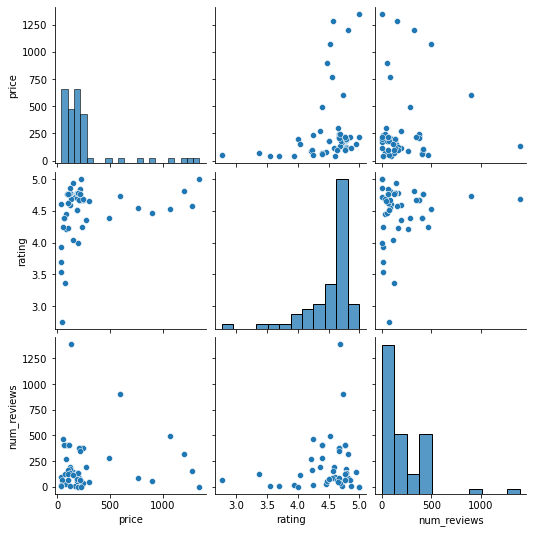

In [115]:
# We fill the NaN reviews with 0 (as it has 0 reviews)
df["num_reviews"] = df["num_reviews"].fillna(value=0).astype("int")

# We fill the NaN ratings with 0 as well
df["rating"] = df["rating"].fillna(value=0)

sns.pairplot(df)

In [301]:
df.describe()

,price,rating,num_reviews
count,60.000000,60.00000,60.000000
mean,85.747333,4.54800,95.733333
std,83.006932,0.33924,137.183023
min,7.990000,4.00000,1.000000
25%,36.492500,4.24000,4.750000
50%,59.990000,4.46000,31.000000
75%,99.565000,4.94000,166.000000
max,519.990000,5.00000,470.000000


<AxesSubplot:>

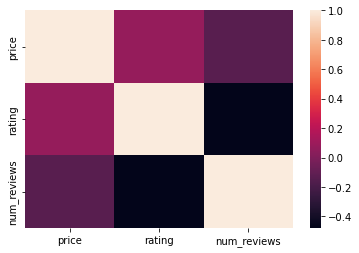

In [302]:
sns.heatmap(df.corr())

### 

## Step 5: Filtering out the data
In this final step we'd like to see the top products having certain attributes to make the best decision.


In [116]:
df_final_choice = df[(df["num_reviews"] > 10) & (df["price"] > 50) & (df["rating"] > 4.7)]
df_final_choice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 7 to 58
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         19 non-null     object 
 1   price        19 non-null     float64
 2   rating       19 non-null     float64
 3   num_reviews  19 non-null     int32  
dtypes: float64(2), int32(1), object(1)
memory usage: 684.0+ bytes


In [120]:
df_final_choice.sort_values(by=["rating"], ascending=False).head(5)

,name,price,rating,num_reviews
7,"Casti Wireless Audio Xenomo® BEAT-X, fara fir,...",149.00,4.94,143
31,"Casti Wireless fara fir Zennic® Sound Pro, Blu...",219.88,4.84,63
11,"Casti Wireless fara fir Zennic® U-Sonic, Bluet...",209.88,4.81,88
17,Casti Apple Airpods Pro (2nd Generation) - 2022,1199.99,4.81,324
44,"Casti wireless bluetooth, POKKOBUDS2, bluetoot...",189.21,4.78,134


## We can see that the top products with the highest ratings are Xenomo, Zennic and Apple (surprise surprise! :)

Its interesting to see that the total reviews for the top 3 products are *still* lower than the reviews done for Apple Airpods. 